In [1]:
# v04_batch_pipeline.py
"""
Batch LiDAR Processing Pipeline (v04)
-------------------------------------
- Modular, well-documented, step-by-step.
- Uses helpers from `src/lidar_utils/` for I/O and processing.
"""
import pathlib
import pandas as pd
import logging
import sys
import os

# Make sure lidar_utils is on sys.path (fine for notebook/dev flows)
SRC = os.path.join(
    os.getcwd(),
    "src")
if SRC not in sys.path:
    sys.path.insert(0, SRC)

from project_utils import io as utils_io
from project_utils import satellite
from project_utils import lidar
from project_utils import raster

# auto-reload any module that changes on disk
%load_ext autoreload
%autoreload 

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

/opt/miniconda3/envs/condavenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Load paths and configs ---
print("Loading config paths from YAML...")
paths = utils_io.load_paths_yaml("config/paths.yml", verbose=True)

# --- Authenticate with earthaccess ---
print("Authenticating earthaccess (will prompt if needed)...")
utils_io.authenticate_earthaccess()

Loading config paths from YAML...
[io] Loading YAML config: config/paths.yml
[io] Paths loaded:
    raw_laz   : data/raw/tiles/laz
    raw_sat   : data/raw/tiles/sat
    raw_meta  : data/raw/metadata
    dtm_dir   : data/derived/dtm
    dsm_dir   : data/derived/dsm
    chm_dir   : data/derived/chm
    hill_dir  : data/derived/hillshade
    pdal_tpl_dir: config/pdal_pipelines
Authenticating earthaccess (will prompt if needed)...
[io] Authenticating with earthaccess...


2025-06-06 21:30:17,646 [INFO] You're now authenticated with NASA Earthdata Login


[io] Authenticated: True


True

In [3]:
# --- Get dataset metadata and download CSV (granule listing) ---
print("\nQuerying dataset metadata and CSV from NASA/ORNL DAAC...")
metadata = utils_io.get_metadata()
concept_id = metadata["meta"]["concept-id"]

csv_path = utils_io.download_earthaccess_dataset_csv(concept_id, dest=paths["raw_meta"], overwrite=False)
print(f"Metadata CSV saved: {csv_path}")

# --- Load into DataFrame and preview ---
df = pd.read_csv(csv_path)
print(f"\nLoaded {len(df)} LiDAR tile entries.")
display(df.head(2))


Querying dataset metadata and CSV from NASA/ORNL DAAC...
[io] Querying metadata for DOI 10.3334/ORNLDAAC/1644


2025-06-06 21:30:23,720 [INFO] Datasets found: 1


[io] Found concept ID: C2398128915-ORNL_CLOUD
[io] Downloading dataset CSV for concept_id: C2398128915-ORNL_CLOUD


2025-06-06 21:30:25,764 [INFO] Granules found: 2
2025-06-06 21:30:26,765 [INFO]  Getting 1 granules, approx download size: 0.0 GB
QUEUEING TASKS | : 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 645.08it/s]2025-06-06 21:30:27,016 [INFO] File cms_brazil_lidar_tile_inventory.csv already downloaded

PROCESSING TASKS | : 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 661.04it/s]
COLLECTING RESULTS | : 100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

[io] CSV downloaded: data/raw/metadata/cms_brazil_lidar_tile_inventory.csv
Metadata CSV saved: data/raw/metadata/cms_brazil_lidar_tile_inventory.csv

Loaded 3152 LiDAR tile entries.


,filename,max_lat,min_lat,max_lon,min_lon,file_type,file_size_mb,file_format,version,created,utmzone,srs
0,ANA_A01_2017_laz_0.laz,-3.363488,-3.372548,-54.992912,-55.001927,pointcloud,85.374953,LAS/LAZ,1.2,214/2017,21S,+proj=utm +zone=21 +south +ellps=GRS80 +towgs8...
1,ANA_A01_2017_laz_1.laz,-3.347679,-3.354482,-55.001946,-55.010093,pointcloud,50.359133,LAS/LAZ,1.2,158/2017,21S,+proj=utm +zone=21 +south +ellps=GRS80 +towgs8...


In [ ]:
filename = "data/raw/tiles/laz/ANA_A01_2017_laz_0.laz"

pipeline = pdal.Pipeline(f"""
[
    {{
        "type": "readers.las",
        "filename": "{filename}"
    }}
]
""")

pipeline.execute()
metadata = pipeline.metadata

classification_counts = metadata['metadata']['readers.las']['dimensions']['Classification']['counts']
total_points = sum(classification_counts.values())

print("Classification\tCount\tPercentage")
for class_id, count in sorted(classification_counts.items(), key=lambda x: int(x[0])):
    percentage = (count / total_points) * 100
    print(f"{class_id}\t\t{count}\t{percentage:.2f}%")


KeyError: 'dimensions'

In [ ]:
import pdal
print(f"pdal.__file__: {pdal.__file__}")
print(f"pdal.__version__: {pdal.__version__}")
print(dir(pdal.Pipeline))

pdal.__file__: /Users/jamesbyers/code/github/Kaggle/openai_to_z/venv/lib/python3.13/site-packages/pdal/__init__.py
pdal.__version__: 3.4.5
['__class__', '__copy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '_copy_inputs', '_del_executor', '_get_json', '_has_inputs', '_pybind11_conduit_v1_', 'arrays', 'execute', 'execute_streaming', 'get_dataframe', 'get_meshio', 'inputs', 'iterator', 'log', 'loglevel', 'meshes', 'metadata', 'pipeline', 'quickinfo', 'schema', 'srswkt2', 'stages', 'streamable', 'toJSON']


: 

: 

: 

In [5]:
# --- Load your PDAL DTM/DSM pipeline templates (JSON, can be small .json files you prepared) ---
print("Loading PDAL pipeline templates...")
pipeline_dir = paths["pdal_tpl_dir"]
pipeline_defs = {
    "dtm": pipeline_dir / "dtm_pipeline.json",
    "dsm": pipeline_dir / "dsm_pipeline.json",
}
for k, v in pipeline_defs.items():
    print(f"  {k.upper()} pipeline: {v}")

Loading PDAL pipeline templates...
  DTM pipeline: config/pdal_pipelines/dtm_pipeline.json
  DSM pipeline: config/pdal_pipelines/dsm_pipeline.json


In [6]:
print("Pipeline dir:", pipeline_dir)
print("DTM template exists:", (pipeline_dir / "dtm_pipeline.json").exists())

Pipeline dir: config/pdal_pipelines
DTM template exists: True


In [7]:
def process_tile(row, pipeline_defs, paths, df):
    """
    Run the full workflow for a single LiDAR tile.
    """
    filename = row["filename"]
    print(f"\n--- Processing tile: {filename} ---")

    # 1. Download LAZ if needed
    laz_path = utils_io.fetch_laz_file(filename, paths["raw_laz"], verbose=True)
    print(f"LAZ file on disk: {laz_path}")

    # 2. Compute spatial bounds for output rasters
    bounds = lidar.tile_bounds(laz_path, res=2.0)
    min_x, max_x, min_y, max_y = bounds
    print(f"Tile bounds: X=({min_x}, {max_x})  Y=({min_y}, {max_y})")

    # 3. Output file locations
    stem = pathlib.Path(filename).stem
    dtm_path  = paths["dtm_dir"]  / f"{stem}_dtm.tif"
    dsm_path  = paths["dsm_dir"]  / f"{stem}_dsm.tif"
    chm_path  = paths["chm_dir"]  / f"{stem}_chm.tif"
    hill_path = paths["hill_dir"] / f"{stem}_hill.tif"
    sat_file  = paths["raw_sat"]  / f"{stem}.jpg"

    print(f"Plan to write: \n  DTM={dtm_path}\n  DSM={dsm_path}\n  CHM={chm_path}\n  Hillshade={hill_path}\n  SAT={sat_file}")

    # 4. Build/run DTM PDAL pipeline
    print("Building and running DTM pipeline...")
    dtm_tpl = lidar.load_template(pipeline_defs["dtm"])
    dtm_pipe = lidar.build_pipeline(dtm_tpl, in_laz=laz_path, out_tif=dtm_path)
    lidar.run_pipeline(dtm_pipe)
    print(f"DTM written: {dtm_path}")

    # 5. Build/run DSM PDAL pipeline
    print("Building and running DSM pipeline...")
    dsm_tpl = lidar.load_template(pipeline_defs["dsm"])
    dsm_pipe = lidar.build_pipeline(dsm_tpl, in_laz=laz_path, out_tif=dsm_path)
    lidar.run_pipeline(dsm_pipe)
    print(f"DSM written: {dsm_path}")

    # 6. Generate CHM, Hillshade
    print("Calculating CHM and hillshade products...")
    raster.create_chm(dsm_path, dtm_path, chm_path)
    raster.hillshade(dtm_path, hill_path)
    print(f"CHM, hillshade complete.")

    # 7. Download satellite image for tile bounds
    print("Fetching satellite image for tile...")
    satellite.fetch_esri_from_row(df, filename, save_path=sat_file)
    print(f"Satellite image saved: {sat_file}")

    return {
        "dtm": dtm_path,
        "dsm": dsm_path,
        "chm": chm_path,
        "hill": hill_path,
        "sat": sat_file
    }

In [12]:
# Process N tiles for demo; set NUM_TILES = None to run over *all*
NUM_TILES = 2  # for dev/test: set to None to do all tiles

for count, (_, row) in enumerate(df.iterrows()):
    if NUM_TILES and count >= NUM_TILES:
        break
    out = process_tile(row, pipeline_defs, paths, df)
    print(f"\nResult paths for {row['filename']}:\n{out}")


--- Processing tile: ANA_A01_2017_laz_0.laz ---
[io] ANA_A01_2017_laz_0.laz already exists in data/raw/tiles/laz, skipping download.
LAZ file on disk: data/raw/tiles/laz/ANA_A01_2017_laz_0.laz
[lidar] Getting tile bounds for data/raw/tiles/laz/ANA_A01_2017_laz_0.laz...
[lidar] Bounds: x=(722000.0, 722999.99), y=(9627000.0, 9627999.99)
Tile bounds: X=(722000.0, 722999.99)  Y=(9627000.0, 9627999.99)
Plan to write: 
  DTM=data/derived/dtm/ANA_A01_2017_laz_0_dtm.tif
  DSM=data/derived/dsm/ANA_A01_2017_laz_0_dsm.tif
  CHM=data/derived/chm/ANA_A01_2017_laz_0_chm.tif
  Hillshade=data/derived/hillshade/ANA_A01_2017_laz_0_hill.tif
  SAT=data/raw/tiles/sat/ANA_A01_2017_laz_0.jpg
Building and running DTM pipeline...
[lidar] Loading pipeline template from: config/pdal_pipelines/dtm_pipeline.json
[lidar] Building PDAL pipeline from template...
[lidar] Running PDAL pipeline with 4 stages...
[lidar] PDAL complete, 1439273 points processed.
DTM written: data/derived/dtm/ANA_A01_2017_laz_0_dtm.tif
Bui

ValueError: operands could not be broadcast together with shapes (376,453) (376,452) 

In [40]:
# Process N tiles for demo; set NUM_TILES = None to run over *all*
TILE_INDEX = 27
row = df.iloc[TILE_INDEX]
out = process_tile(row, pipeline_defs, paths, df)
print(f"\nResult paths for {row['filename']}:\n{out}")


--- Processing tile: AND_A01_2013_laz_10.laz ---
[io] AND_A01_2013_laz_10.laz already exists in data/raw/tiles/laz, skipping download.
LAZ file on disk: data/raw/tiles/laz/AND_A01_2013_laz_10.laz
[lidar] Getting tile bounds for data/raw/tiles/laz/AND_A01_2013_laz_10.laz...
[lidar] Bounds: x=(295999.18, 296750.0), y=(9715999.950000001, 9717000.14)
Tile bounds: X=(295999.18, 296750.0)  Y=(9715999.950000001, 9717000.14)
Plan to write: 
  DTM=data/derived/dtm/AND_A01_2013_laz_10_dtm.tif
  DSM=data/derived/dsm/AND_A01_2013_laz_10_dsm.tif
  CHM=data/derived/chm/AND_A01_2013_laz_10_chm.tif
  Hillshade=data/derived/hillshade/AND_A01_2013_laz_10_hill.tif
  SAT=data/raw/tiles/sat/AND_A01_2013_laz_10.jpg
Building and running DTM pipeline...
[lidar] Loading pipeline template from: config/pdal_pipelines/dtm_pipeline.json
[lidar] Building PDAL pipeline from template...
[lidar] Running PDAL pipeline with 2 stages...
[lidar] PDAL complete, 28469600 points processed.
DTM written: data/derived/dtm/AND_


Visualizing results of last processed tile...
[vis] Generating quick-look plot...


/opt/miniconda3/envs/condavenv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


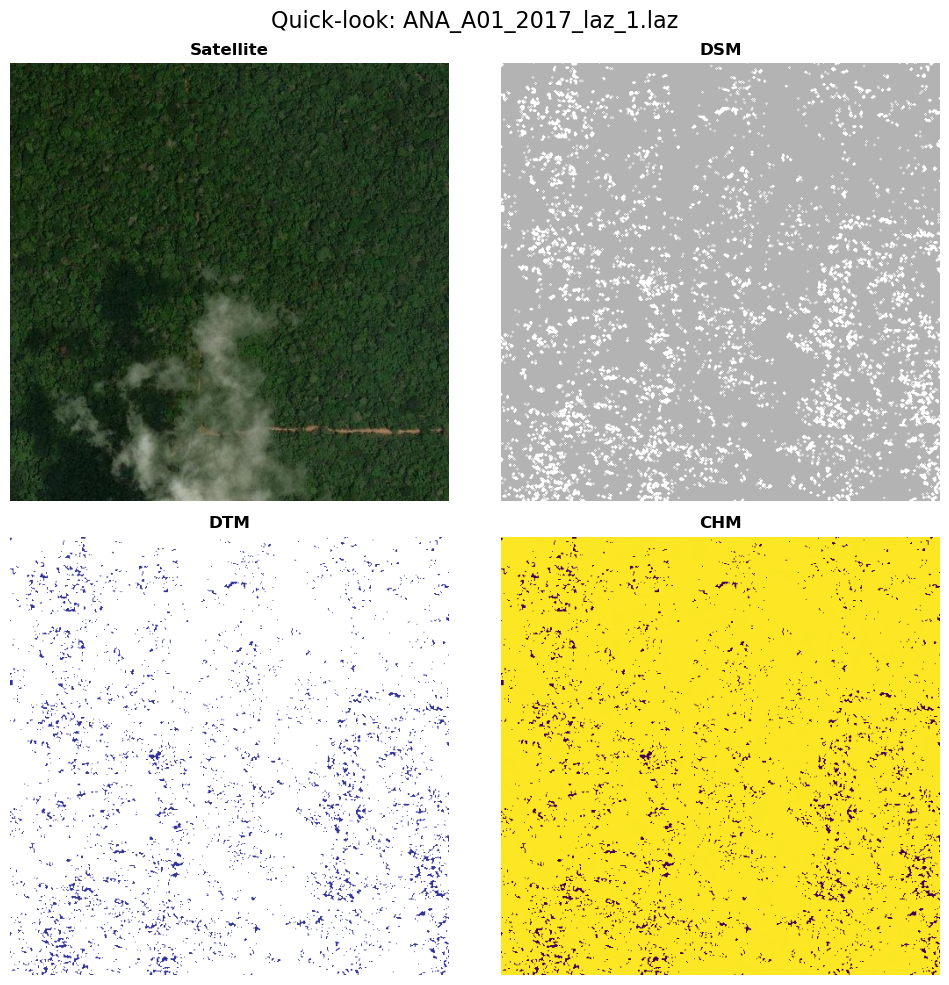

In [13]:
from project_utils import vis

# Visualize the last processed tile
print("\nVisualizing results of last processed tile...")
vis.plot_products(
    sat_jpg=out["sat"],
    dsm_path=out["dsm"],
    dtm_path=out["dtm"],
    chm_path=out["chm"],
    hill_path=out["hill"],
    overlay="hillshade",
    title=f"Quick-look: {row['filename']}"
)

In [43]:
import rasterio
import matplotlib.pyplot as plt

temp_files_chm = os.listdir(os.path.join(
    os.getcwd(),
    "data",
    "derived",
    "hillshade"))
print(temp_files_chm)


['ANA_A01_2017_laz_0_hill.tif', 'ANA_A01_2017_laz_1_hill.tif', 'AND_A01_2013_laz_10_hill.tif', 'AND_A01_2013_laz_11_hill.tif']


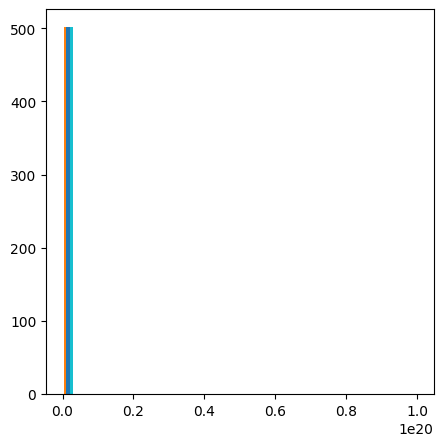

In [54]:
fig = plt.figure(figsize=(5,5))
plt.hist(arr, bins=30)
plt.show()

In [71]:
import numpy as np
data = arr
Q1 = np.percentile(data, 0.05)
Q3 = np.percentile(data, 0.95)
IQR = Q3 - Q1

# Define bounds for anomaly detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out anomalies
cleaned_arr = np.where(
    (arr < lower_bound) | (arr > upper_bound),
    np.nan,
    arr
)


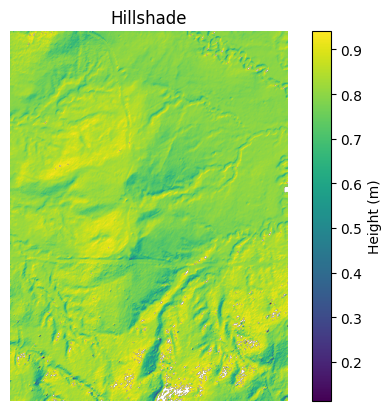

In [72]:

plt.imshow(cleaned_arr, cmap='viridis')
plt.title('Hillshade')
plt.colorbar(label='Height (m)')
plt.axis('off')
plt.show()

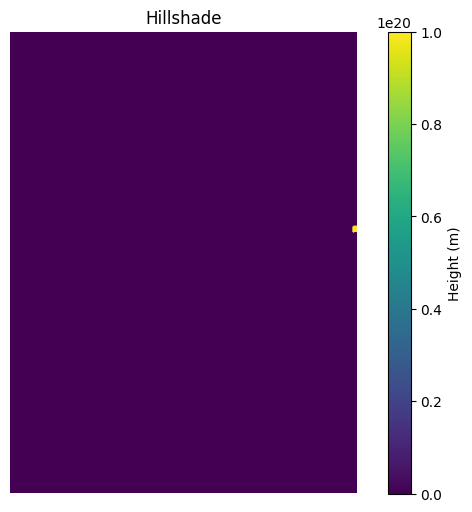

In [ ]:
temp_path = os.path.join(
    os.getcwd(),
    "data",
    "derived",
    "hillshade",
    temp_files_chm[3]
)
with rasterio.open(temp_path) as src:
    arr = src.read(1)
    plt.figure(figsize=(8,6))
    plt.imshow(arr, cmap='viridis')
    plt.title('Hillshade')
    plt.colorbar(label='Height (m)')
    plt.axis('off')
    plt.show()